# Baseline
## SwinIR 
![swinir](https://raw.githubusercontent.com/JingyunLiang/SwinIR/main/figs/SwinIR_archi.png)

- arxiv: https://arxiv.org/pdf/2108.10257.pdf
- github: https://github.com/JingyunLiang/SwinIR

## Import

In [1]:
import os
import warnings
import random
from pprint import pprint
import copy
from typing import List, Tuple
from glob import glob
import json
import csv
import gc
from dataclasses import dataclass
from joblib import Parallel, delayed

from tqdm import tqdm
import numpy as np
import pandas as pd
from box import Box
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import tifffile

from sklearn.model_selection import StratifiedKFold, KFold
import torch
import torch.optim as optim
import torch.nn as nn
from torch import Tensor
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from timm import create_model

from pytorch_lightning import Trainer
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks import RichProgressBar, TQDMProgressBar
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.progress.rich_progress import RichProgressBarTheme
from pytorch_lightning.callbacks.progress import ProgressBarBase
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from pytorch_lightning import LightningDataModule, LightningModule

import ignite

import wandb
wandb.login(key='****')

warnings.filterwarnings("ignore")

torch.autograd.set_detect_anomaly(True)
pd.options.display.max_colwidth = 250
pd.options.display.max_rows = 30

# インライン表示
%matplotlib inline

/home/ss/anaconda3/envs/s-sr-2023/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: syuchimu. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ss/.netrc


## Config

In [2]:
from typing import List, Set, Dict, Any

class CFG(object):
    # basic
    debug: bool = False
    debug_sample: int = 128
    folds: int  = 4
    seed: int   = 417
    eps: float  = 1e-12
    outdir: str = 'output/'
    
    # data
    DATA_ROOT: str  =  f'../../data/'
    
    preprocess: Dict[str, int] = {
        "input_size": 130,
        "upscale": 5,
        "output_size": 650
    }
    
    # train
    epoch: int  = 40
    trainer: Dict[str, Any]   = {
        'gpus': 1,
        'accumulate_grad_batches': 1,
        'fast_dev_run': False,
        'num_sanity_val_steps': 0,
        'resume_from_checkpoint': None,
        'check_val_every_n_epoch': 2,
        'val_check_interval': 1.0,
        # 'precision' : 16,
        'gradient_clip_val': 25., 
        'gradient_clip_algorithm': "value"
    }
    optimizer: Dict[str, Any] = {
        'name': 'optim.AdamW',
        'params': {
            'lr': 1e-3,
            },
    }
    scheduler: Dict[str, Any] = {
        'name': 'optim.lr_scheduler.CosineAnnealingWarmRestarts',
        'params':{
            'T_0': 20,
            'eta_min': 1e-5,
            }
    }
    model: Dict[str, Any] = {
        # config: https://github.com/JingyunLiang/SwinIR/blob/main/main_test_swinir.py
        "swinir": {
            'upscale': preprocess['upscale'],
            'img_size': (-1, -1),
            'window_size': 7,
            'img_range': 255.,
            'depths': [6, 6, 6, 6, 6, 6],
            'embed_dim': 60,
            'num_heads': [6, 6, 6, 6, 6, 6],
            'mlp_ratio': 2,
            'upsampler': 'pixelshuffledirect', # nearest+conv, pixelshuffledirect, pixelshuffle
            'resi_connection': '1conv',
        }
    }
    train_loader: Dict[str, Any] = {
        'batch_size': 16,
        'shuffle': True,
        'num_workers': 16,
        'pin_memory': False,
        'drop_last': True,
    }
    val_loader :Dict[str, Any]= {
        'batch_size': 16,
        'shuffle': False,
        'num_workers': 16,
        'pin_memory': False,
        'drop_last': False
    }
    
    
    info = ''
    
    # model info
    info += f'SwinIR_W{model["swinir"]["window_size"]}D{len(model["swinir"]["depths"])}'
    info += f'E{model["swinir"]["embed_dim"]}H{len(model["swinir"]["num_heads"])}Unc'
    # train info
    info += f'_{optimizer["name"].split(".")[1]}{optimizer["params"]["lr"]}{scheduler["params"]["eta_min"]}_E{epoch}_fl-tr'
    
    # logging
    project: str = "Solafune-SR-2023"
    runname: str = "A6000"
    group: str   = f'A6000_V1_IMG{preprocess["input_size"]}_{info}_B{train_loader["batch_size"]}'
    notebook: str = '001_baseline.ipynb'
    
    # post info
    augmentation: str =  ''
    fold: int = -1

    if debug:
        epoch = 10
        group = 'DEBUG'


# box
cfg = Box({k:v for k, v in dict(vars(CFG)).items() if '__' not in k})
    
# 乱数のシードを設定
seed_everything(cfg.seed)
torch.manual_seed(cfg.seed)
np.random.seed(cfg.seed)
random.seed(cfg.seed)
    
pprint(cfg)

Global seed set to 417


{'DATA_ROOT': '../../data/',
 'augmentation': '',
 'debug': False,
 'debug_sample': 128,
 'epoch': 40,
 'eps': 1e-12,
 'fold': -1,
 'folds': 4,
 'group': 'A6000_V1_IMG130_SwinIR_W7D6E60H6Unc_AdamW0.0011e-05_E40_fl-tr_B16',
 'info': 'SwinIR_W7D6E60H6Unc_AdamW0.0011e-05_E40_fl-tr',
 'model': {'swinir': {'depths': BoxList([6, 6, 6, 6, 6, 6]),
                      'embed_dim': 60,
                      'img_range': 255.0,
                      'img_size': (-1, -1),
                      'mlp_ratio': 2,
                      'num_heads': BoxList([6, 6, 6, 6, 6, 6]),
                      'resi_connection': '1conv',
                      'upsampler': 'pixelshuffledirect',
                      'upscale': 5,
                      'window_size': 7}},
 'notebook': '001_baseline.ipynb',
 'optimizer': Box({'name': 'optim.AdamW', 'params': {'lr': 0.001}}),
 'outdir': 'output/',
 'preprocess': Box({'input_size': 130, 'upscale': 5, 'output_size': 650}),
 'project': 'Solafune-SR-2023',
 'runname': '

In [3]:
pad_size = (cfg.preprocess.output_size // cfg.preprocess.upscale \
    // cfg.model.swinir.window_size + 1) * cfg.model.swinir.window_size
print('MODEL INPUT SIZE:', pad_size)
cfg.model.swinir.img_size = (pad_size, pad_size)

MODEL INPUT SIZE: 133


## Augmentation

In [4]:
# augmentation
tf_dict = {
    
    'train': A.Compose(
        [

            # A.CoarseDropout(max_holes=4, max_height=4, max_width=4, 
            #                     min_holes=None, min_height=None, min_width=None, 
            #                     fill_value=0.15, mask_fill_value=0.0, always_apply=False, p=0.25),
            # A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, interpolation=1,
            #                     border_mode=4, value=None, mask_value=None, always_apply=False,
            #                     approximate=False, same_dxdy=False, p=0.25),
            # A.GridDistortion(num_steps=5, distort_limit=0.4, interpolation=1, 
            #                     border_mode=4, value=None, mask_value=None, always_apply=False, p=0.25),
            # A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, interpolation=1, 
            #                     border_mode=4, value=0.01, mask_value=0.0, shift_limit_x=None, shift_limit_y=None, 
            #                     p=0.5),
            # A.OneOf([
            #     # A.GaussNoise(var_limit=(1e-3, 8e-1), mean=0.15, p=0.5),
            #     A.Blur(blur_limit=9, p=0.25),
            #     A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, brightness_by_max=True, p=0.5),
            # ], p=0.9),
            A.Transpose(p=0.25),
            A.Flip(p=0.5),
            # A.HueSaturationValue (hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=5, p=0.5),
            # A.Rotate(limit=30, p=0.5),
            # A.Resize(cfg.preprocess.input_size, cfg.preprocess.input_size),
    #         A.Normalize(mean=(0.485), std=(0.229)),
            ToTensorV2(),
            ]
        ),
    'val': A.Compose(
        [
            # A.Resize(cfg.preprocess.input_size, cfg.preprocess.input_size),
            # A.Normalize(mean=(0.485), std=(0.229)),
            ToTensorV2(),
        ]
    ),
}

tf_dict['test'] = tf_dict['val']

cfg.augmentation = str(tf_dict).replace('\n', '').replace(' ', '')
cfg.augmentation

"{'train':Compose([Transpose(always_apply=False,p=0.25),Flip(always_apply=False,p=0.5),ToTensorV2(always_apply=True,p=1.0,transpose_mask=False),],p=1.0,bbox_params=None,keypoint_params=None,additional_targets={}),'val':Compose([ToTensorV2(always_apply=True,p=1.0,transpose_mask=False),],p=1.0,bbox_params=None,keypoint_params=None,additional_targets={}),'test':Compose([ToTensorV2(always_apply=True,p=1.0,transpose_mask=False),],p=1.0,bbox_params=None,keypoint_params=None,additional_targets={})}"

## DataSet

In [5]:
class SolafuneSR2023Dataset(Dataset):
    def __init__(self,
                 df,
                 phase: str='train',
                 is_path: bool=False,
                 ):
        """ pytorch dataset for Solafune Super Resolution 2023 data. """
        self.df = df
        self.phase = phase
        self.is_path = is_path
        self.transform = tf_dict[self.phase]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        
        img_l = tifffile.imread(row.path_low)
        
        if self.phase == 'test':
            img = self.transform(image=img_l)["image"]
            in_pad = torch.zeros((3, *cfg.model.swinir.img_size), dtype=torch.float32)
            in_pad[:, :cfg.preprocess.input_size, :cfg.preprocess.input_size] = img
            return in_pad, row.path_low

        else:
            img_h = tifffile.imread(row.path_high)
            
            # augmentation
            transformed = self.transform(image=img_l, mask=img_h)
            
            img = transformed["image"]
            mask = transformed["mask"].permute(2, 0, 1)
            
            # padding
            in_pad = torch.zeros((3, *cfg.model.swinir.img_size), dtype=torch.float32)
            in_pad[:, :cfg.preprocess.input_size, :cfg.preprocess.input_size] = img
            
            if self.is_path:
                return in_pad, mask, row.path_low
            
            return in_pad, mask
    
class SolafuneSR2023Module(LightningDataModule):
    
    def __init__(
        self,
        df_train,
        df_val,
        cfg,
    ):
        """ pytorch lightning datamodeule for Solafune Super Resolution 2023 data. """
        super().__init__()
        self.df_train = df_train
        self.df_val = df_val
        self._cfg = cfg

    def train_dataloader(self):
        dataset = SolafuneSR2023Dataset(self.df_train, phase='train')
        return DataLoader(dataset, **self._cfg.train_loader)

    def val_dataloader(self):
        dataset = SolafuneSR2023Dataset(self.df_val, phase='val')
        return DataLoader(dataset, **self._cfg.val_loader)

## Model

- swinir: https://github.com/JingyunLiang/SwinIR/blob/main/models/network_swinir.py
- ssim loss: https://zenn.dev/taikiinoue45/articles/bf7d2314ab4d10

In [6]:
class SSIMpixLoss(nn.Module):
    def __init__(self, kernel_size: int = 11, sigma: float = 1.5, loss_weight: float=1.0, reduction='mean') -> None:

        """Computes the structural similarity (SSIM) index map between two images.
        Args:
            kernel_size (int): Height and width of the gaussian kernel.
            sigma (float): Gaussian standard deviation in the x and y direction.
        """

        super().__init__()
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.loss_weight = loss_weight
        self.gaussian_kernel = self._create_gaussian_kernel(self.kernel_size, self.sigma)

    def forward(self, x: Tensor, y: Tensor, as_loss: bool = True) -> Tensor:

        if not self.gaussian_kernel.is_cuda:
            self.gaussian_kernel = self.gaussian_kernel.to(x.device)

        ssim_map = self._ssim(x, y) 
        num_nan = torch.isnan(ssim_map).float().sum()
        assert num_nan < 0.5, f'ssim NaN! NUM:{num_nan}'
        

        if as_loss:
            return (2. - ssim_map.mean()) * self.loss_weight
        else:
            return ssim_map * self.loss_weight

    def _ssim(self, x: Tensor, y: Tensor) -> Tensor:

        # Compute means
        ux = F.conv2d(x, self.gaussian_kernel, padding=self.kernel_size // 2, groups=3)
        uy = F.conv2d(y, self.gaussian_kernel, padding=self.kernel_size // 2, groups=3)

        # Compute variances
        uxx = F.conv2d(x * x, self.gaussian_kernel, padding=self.kernel_size // 2, groups=3)
        uyy = F.conv2d(y * y, self.gaussian_kernel, padding=self.kernel_size // 2, groups=3)
        uxy = F.conv2d(x * y, self.gaussian_kernel, padding=self.kernel_size // 2, groups=3)
        vx = uxx - ux * ux
        vy = uyy - uy * uy
        vxy = uxy - ux * uy

        c1 = 0.01 ** 2
        c2 = 0.03 ** 2
        numerator = (2 * ux * uy + c1) * (2 * vxy + c2)
        denominator = (ux ** 2 + uy ** 2 + c1) * (vx + vy + c2)
        
        num_nan = torch.isnan(denominator).float().sum()
        assert num_nan < 0.5, f'd NaN! NUM:{num_nan}'
        
        num_nan = torch.isnan(numerator).float().sum()
        assert num_nan < 0.5, f'n NaN! NUM:{num_nan}'
        
        return numerator / (denominator + 1e-12)

    def _create_gaussian_kernel(self, kernel_size: int, sigma: float) -> Tensor:

        start = (1 - kernel_size) / 2
        end = (1 + kernel_size) / 2
        kernel_1d = torch.arange(start, end, step=1, dtype=torch.float32)
        kernel_1d = torch.exp(-torch.pow(kernel_1d / sigma, 2) / 2)
        kernel_1d = (kernel_1d / (kernel_1d.sum())).unsqueeze(dim=0)

        kernel_2d = torch.matmul(kernel_1d.t(), kernel_1d)
        kernel_2d = kernel_2d.expand(3, 1, kernel_size, kernel_size).contiguous()
        return kernel_2d

In [7]:
from models.swinir import SwinIR 


def mixup(x: torch.Tensor, y: torch.Tensor, alpha: float = 1.0):
    assert alpha > 0, "alpha should be larger than 0"
    assert x.size(0) > 1, "Mixup cannot be applied to a single instance."

    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size()[0])
    mixed_x = lam * x + (1 - lam) * x[rand_index, :]
    target_a, target_b = y, y[rand_index]
    return mixed_x, target_a, target_b, lam

class SRModel(LightningModule):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.__build_model()
        self.ssim_max = 0.0
        
        self.mse = nn.MSELoss()
        self.mae = nn.L1Loss()
        self.criterion = SSIMpixLoss()

    def __build_model(self):
        self.backbone = SwinIR(**self.cfg.model.swinir)

    def forward(self, x):
        f = self.backbone(x)
        f = f[:, :, :self.cfg.preprocess.output_size, :self.cfg.preprocess.output_size] # batch, channel, height, width
        f = torch.clamp(f, min=0.0, max=255.0)
        return f

    def training_step(self, batch, batch_idx):
        return self.__share_step(batch, 'train')
        
    def validation_step(self, batch, batch_idx):
        return self.__share_step(batch, 'val')

    def __share_step(self, batch, mode):
        imgs_l, imgs_h = batch
        imgs_l, imgs_h = imgs_l.float(), imgs_h.float()

        preds_h = self.forward(imgs_l)
        loss = self.criterion(preds_h ,imgs_h, as_loss=True)
        
        # mertics
        ssim_map = self.criterion(preds_h ,imgs_h, as_loss=False).detach()
        ssim = ssim_map.mean().cpu()
        mse  = self.mse(preds_h ,imgs_h).detach().cpu()
        mae  = self.mae(preds_h ,imgs_h).detach().cpu()

        return {'loss': loss, 'mae': mse, 'mse': mae, 'ssim': ssim }
        
    def training_epoch_end(self, outputs):
        self.__share_epoch_end(outputs, 'train')

    def validation_epoch_end(self, outputs):
        self.__share_epoch_end(outputs, 'val')    
        
    def __share_epoch_end(self, outputs, mode):
        
        ssims, maes, mses, losses = [], [], [], []
        for out in outputs:
            ssim, mae, mse, loss = out['ssim'], out['mse'], out['mae'], out['loss'].detach().cpu()
            
            losses.append(loss)
            maes.append(mae)
            mses.append(mse)
            ssims.append(ssim)
        
        losses = np.mean(losses)
        ssims = np.mean(ssims)
        mses = np.mean(mses)
        maes = np.mean(maes)

        self.log(f'{mode}/loss', losses)
        self.log(f'{mode}/ssim', ssims)
        self.log(f'{mode}/mse', mses)
        self.log(f'{mode}/mae', maes)
        
        if mode == 'val':
            if self.ssim_max < ssim:
                self.ssim_max = ssims
            # logging val max ssim
            self.log(f'{mode}/ssim_max', self.ssim_max)

    def configure_optimizers(self):
        optimizer = eval(self.cfg.optimizer.name)(
            self.parameters(), **self.cfg.optimizer.params
        )
        scheduler = eval(self.cfg.scheduler.name)(
            optimizer,
            **self.cfg.scheduler.params
        )
        return [optimizer], [scheduler]

## Meta

In [8]:
df = pd.read_csv(f'{cfg.DATA_ROOT}train.csv')
df.head(3)

,path_high,path_low,high_hight,high_width,high_dtype,high_r_mean,high_r_std,high_g_mean,high_g_std,high_b_mean,high_b_std,low_hight,low_width,low_dtype,low_r_mean,low_r_std,low_g_mean,low_g_std,low_b_mean,low_b_std
0,../../data/train/train_0_high.tif,../../data/train/train_0_low.tif,650,650,uint8,45.250045,13.765331,46.895564,13.728972,46.593484,13.723393,130,130,uint8,45.249408,6.478374,46.895148,6.534679,46.592663,6.380026
1,../../data/train/train_1000_high.tif,../../data/train/train_1000_low.tif,650,650,uint8,45.298123,23.020507,49.475520,18.634012,49.695782,18.504302,130,130,uint8,45.299290,21.654118,49.468047,16.306142,49.690059,16.145339
2,../../data/train/train_1001_high.tif,../../data/train/train_1001_low.tif,650,650,uint8,61.594660,17.453135,52.473825,15.959983,52.367337,15.059282,130,130,uint8,61.592367,16.313117,52.469231,14.552393,52.364438,13.552943


In [9]:
if cfg.debug:
    df = df[:cfg.debug_sample]
    print('DEBUG MODE:  num sample is', cfg.debug_sample)

## Fold

In [10]:
n_fold = np.zeros(len(df))
skf = KFold(n_splits=cfg.folds, shuffle=True, random_state=cfg.seed)
for fold, (_, val_idx) in enumerate(skf.split(range(len(df)))):
    n_fold[val_idx] = fold
    
df["fold"] = n_fold.astype(np.uint16)
display(df.head(6))

,path_high,path_low,high_hight,high_width,high_dtype,high_r_mean,high_r_std,high_g_mean,high_g_std,high_b_mean,...,low_hight,low_width,low_dtype,low_r_mean,low_r_std,low_g_mean,low_g_std,low_b_mean,low_b_std,fold
0,../../data/train/train_0_high.tif,../../data/train/train_0_low.tif,650,650,uint8,45.250045,13.765331,46.895564,13.728972,46.593484,...,130,130,uint8,45.249408,6.478374,46.895148,6.534679,46.592663,6.380026,1
1,../../data/train/train_1000_high.tif,../../data/train/train_1000_low.tif,650,650,uint8,45.298123,23.020507,49.475520,18.634012,49.695782,...,130,130,uint8,45.299290,21.654118,49.468047,16.306142,49.690059,16.145339,0
2,../../data/train/train_1001_high.tif,../../data/train/train_1001_low.tif,650,650,uint8,61.594660,17.453135,52.473825,15.959983,52.367337,...,130,130,uint8,61.592367,16.313117,52.469231,14.552393,52.364438,13.552943,0
3,../../data/train/train_1002_high.tif,../../data/train/train_1002_low.tif,650,650,uint8,52.199780,19.574048,58.073176,19.580622,59.755778,...,130,130,uint8,52.200355,17.952422,58.073314,17.921159,59.758757,15.653567,1
4,../../data/train/train_1003_high.tif,../../data/train/train_1003_low.tif,650,650,uint8,45.048622,10.191469,43.722007,10.348676,44.099176,...,130,130,uint8,45.046686,4.734852,43.720355,4.858936,44.100769,4.675110,1
5,../../data/train/train_1004_high.tif,../../data/train/train_1004_low.tif,650,650,uint8,50.319314,20.779474,52.735155,20.338314,59.509962,...,130,130,uint8,50.320414,18.557574,52.736627,17.483539,59.504497,17.223114,3


## Visualize

torch.Size([16, 3, 133, 133]) torch.Size([16, 3, 650, 650])


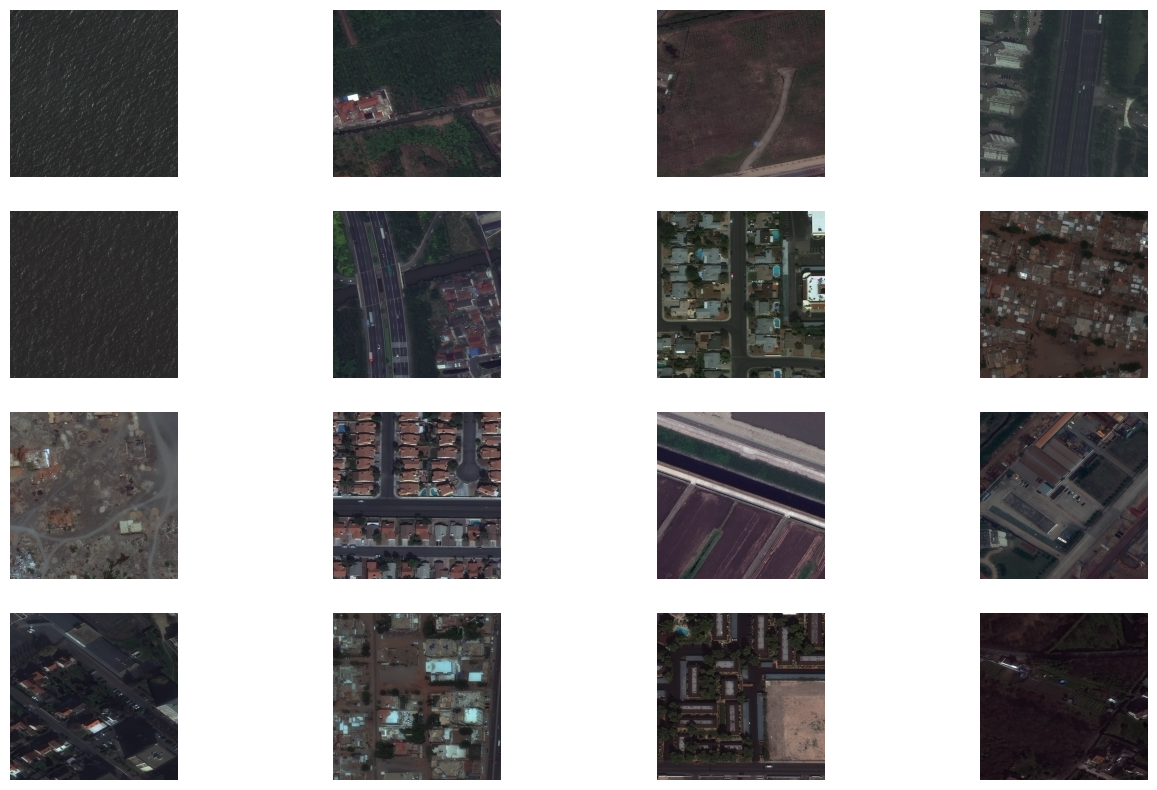

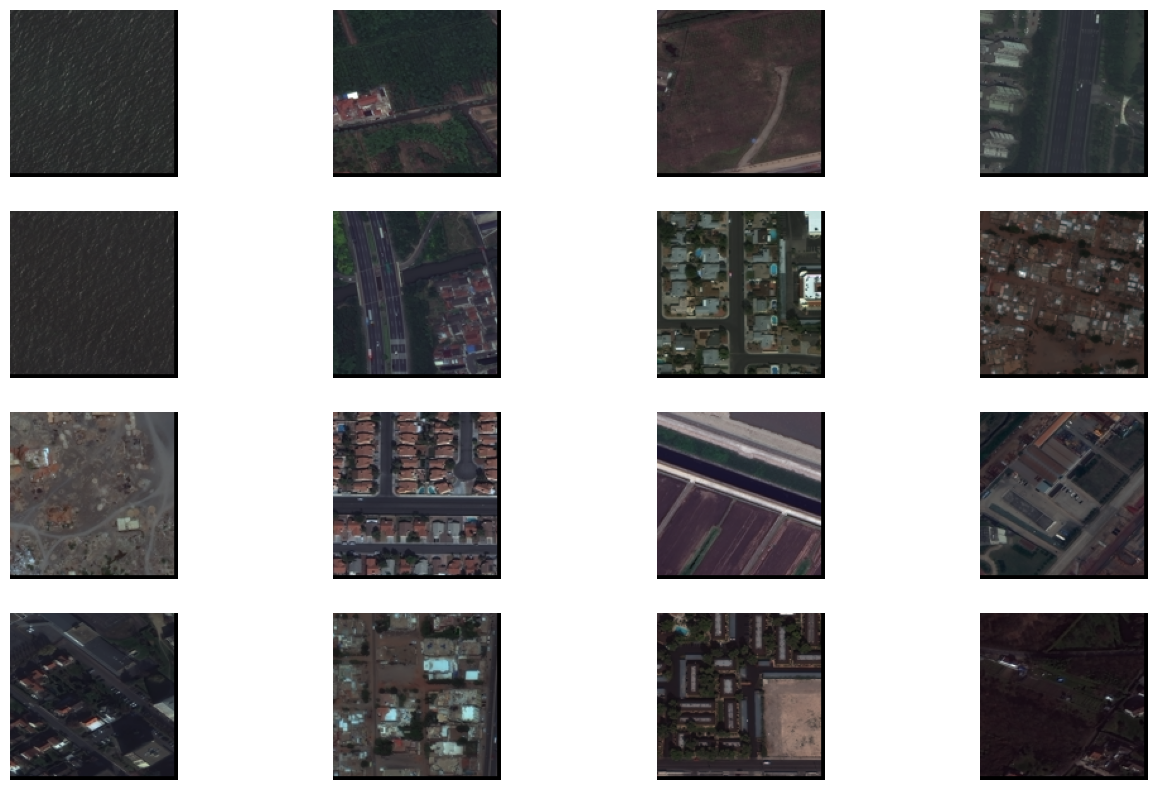

In [11]:
sample_dataloader = SolafuneSR2023Module(df, df, cfg).val_dataloader()
imgs_l, imgs_h = next(iter(sample_dataloader))
print(imgs_l.shape, imgs_h.shape)

num = 16

plt.figure(figsize=(16, 10), facecolor='white')
plt.title('Vizualuze High Resolution')
for it, image in enumerate(imgs_h[:num]):
    plt.subplot(4, 4, it+1)
    plt.imshow(image.permute(1, 2, 0).numpy().astype(np.uint8))
    plt.axis('off')
plt.savefig(f'{cfg.outdir}visualization_high.png')
plt.show();

plt.figure(figsize=(16, 10), facecolor='white')
plt.title('Vizualuze Low Resolution')
for it, image in enumerate(imgs_l[:num]):
    plt.subplot(4, 4, it+1)
    plt.imshow(image.permute(1, 2, 0).numpy().astype(np.uint8))
    plt.axis('off')
plt.savefig(f'{cfg.outdir}visualization_low.png')
plt.show();

## Check

In [12]:
# check size
outputs = SRModel(cfg=cfg)(imgs_l.float())
b, c, h, w = outputs.shape 
print(b, c, h, w)
assert h == w == cfg.preprocess.output_size, f'mismatch 650 size -> H{h} W{w}'

# inputs = torch.zeros(imgs_l.shape, dtype=imgs_l.dtype)
criterion = SSIMpixLoss()
loss = criterion(outputs, imgs_h.float())
print(loss.shape, loss)

16 3 650 650
torch.Size([]) tensor(1.9987, grad_fn=<MulBackward0>)


In [13]:
plt.close()
plt.clf();
del sample_dataloader, imgs_l, imgs_h, n_fold, outputs, criterion, loss
gc.collect()

31437

<Figure size 640x480 with 0 Axes>

## Train

In [14]:
for fold in range(cfg.folds):
    print('■'*30, f"fold: {fold}", '■'*30)
    
    # train val split 
    train_df = df[df['fold'] != fold].reset_index(drop=True)
    val_df = df[df['fold'] == fold].reset_index(drop=True)
    print(f'[num sample] train: {len(train_df)} val:{len(val_df)}')
    assert len(train_df) > 0 and len(val_df) > 0, f'[Num Sample] train: {len(train_df)} val:{len(val_df)}'
    
    datamodule = SolafuneSR2023Module(train_df, val_df, cfg)
    model = SRModel(cfg)
    
    # metrics
    logging_dir = f"output/{cfg.group}/{cfg.runname}_fold{fold}"
    loss_checkpoint = callbacks.ModelCheckpoint(
        dirpath=logging_dir ,
        filename="loss",
        monitor="val/loss",
        save_top_k=1,
        mode="min",
        save_last=True,
    )

    # logger
    tb_logger = TensorBoardLogger(logging_dir)
    wandb_logger = WandbLogger(
        name=f'{cfg.runname}-fold{fold}',
        group=cfg.group,
        project=cfg.project,
        config=cfg,
        tags=[f'fold{fold}', 'A6000', 'SwinIR'],
    )
    lr_monitor = callbacks.LearningRateMonitor()
    earystopping = EarlyStopping(monitor="val/loss")
    progress_bar = RichProgressBar(
        theme=RichProgressBarTheme(
            description="green_yellow",
            progress_bar="green1",
            progress_bar_finished="green1",
            progress_bar_pulse="#6206E0",
            batch_progress="green_yellow",
            time="grey82",
            processing_speed="grey82",
            metrics="grey82",
        )
    )
    tddm_callbacks = TQDMProgressBar(refresh_rate=1)
    # rich: https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.callbacks.RichProgressBar.html#pytorch_lightning.callbacks.RichProgressBar
    
    # trainer
    trainer = Trainer(
        logger=[tb_logger,wandb_logger],
        max_epochs=cfg.epoch,
        # callbacks=[lr_monitor, loss_checkpoint, earystopping, progress_bar],
         callbacks=[lr_monitor, loss_checkpoint, tddm_callbacks],
        **cfg.trainer,
    )
    trainer.fit(model, datamodule=datamodule)
    
    # save
    df.to_csv(f'{logging_dir}/fold.csv', index=False)
    cfg.to_json(f'{logging_dir}/cfg.json', indent=4)
    wandb.save(cfg.notebook)
    wandb.finish()
    break

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ fold: 0 ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
[num sample] train: 2250 val:750


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
Missing logger folder: output/A6000_V1_IMG130_SwinIR_W7D6E60H6Unc_AdamW0.0011e-05_E40_fl-tr_B16/A6000_fold0/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type        | Params
------------------------------------------
0 | backbone  | SwinIR      | 1.4 M 
1 | mse       | MSELoss     | 0     
2 | mae       | L1Loss      | 0     
3 | criterion | SSIMpixLoss | 0     
------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.467     Total estimated model params size (MB)


Epoch 3:  29%|██▉       | 54/187 [01:49<04:29,  2.02s/it, loss=1.69, v_num=h83e] 

## Validation

In [ ]:
# 学習済みモデルを確認 
!ls {logging_dir}

cfg.json  fold.csv  last.ckpt  lightning_logs  loss.ckpt


In [ ]:
fold, batch_size = 0, 8
SAVE = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
logging_dir = f"output/{cfg.group}/{cfg.runname}_fold{fold}"

PATH_MODEL = f'{logging_dir}/loss.ckpt'
model = SRModel.load_from_checkpoint(PATH_MODEL, cfg=cfg)
model.eval()
model = model.to(device)

print(f'EVALUATE FOLD: {fold} WEIGHT: {PATH_MODEL}')

EVALUATE FOLD: 0 WEIGHT: output/A6000_V1_IMG130_SwinIR_W7D6E60H6Unc_AdamW0.0011e-05_E100_fl-tr_B8/A6000_fold0/loss.ckpt


In [ ]:
val_df = df[df['fold'] == fold].reset_index(drop=True)
val_ds = SolafuneSR2023Dataset(val_df, is_path=True, phase='val')
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

if SAVE:
    SAVE_DIR = f'{logging_dir}/eval/'
    os.makedirs(SAVE_DIR, exist_ok=True)

FNAMES, PATHS, SCORES,  = [], [], []

for (image, labels, paths) in tqdm(val_dl, leave=False):
    image = image.to(device)
    
    with torch.no_grad():
        logits = model(image)
        preds = torch.round(logits, decimals=0)
    
    preds = preds.cpu().numpy().transpose(0, 2, 3, 1).astype(np.uint8)
    labels = labels.numpy().transpose(0, 2, 3, 1)
    
    # per batch
    for i in range(preds.shape[0]):
        img_h = labels[i]
        pred_h = preds[i]
        path = paths[i]
        
        ssim_score = ssim(img_h, pred_h, multichannel=True)
        
        PATHS.append(path)
        SCORES.append(ssim_score)
        
        FNAME = os.path.basename(path).replace("_low.tif", "_answer.tif")
        FNAMES.append(FNAME)
        
        if SAVE:
            tifffile.imwrite(f'{SAVE_DIR}/{FNAME}', pred_h)

df_preds = pd.DataFrame()
df_preds['file_name'] = FNAMES
df_preds['score'] = SCORES
df_preds['path'] = PATHS

ssim_mean = np.mean(SCORES)

PATH_PRED = f'{logging_dir}/predict_fold{fold}_ssim{ssim_mean:3f}.csv'
df_preds.to_csv(PATH_PRED, index=False)
print(F'>>> csv: {PATH_PRED}')

display(df_preds.head())

100%|██████████| 94/94 [01:22<00:00,  1.15it/s]

>>> csv: output/A6000_V1_IMG130_SwinIR_W7D6E60H6Unc_AdamW0.0011e-05_E100_fl-tr_B8/A6000_fold0/predict_fold0_ssim0.732467.csv


,file_name,score,path
0,train_1000_answer.tif,0.649152,../../data/train/train_1000_low.tif
1,train_1001_answer.tif,0.656910,../../data/train/train_1001_low.tif
2,train_1005_answer.tif,0.780040,../../data/train/train_1005_low.tif
3,train_1008_answer.tif,0.754586,../../data/train/train_1008_low.tif
4,train_1009_answer.tif,0.683344,../../data/train/train_1009_low.tif


SSIM scikit-image => 平均: 0.7324669892816912 最大: 0.8743204637575661 最小: 0.3149033329903077


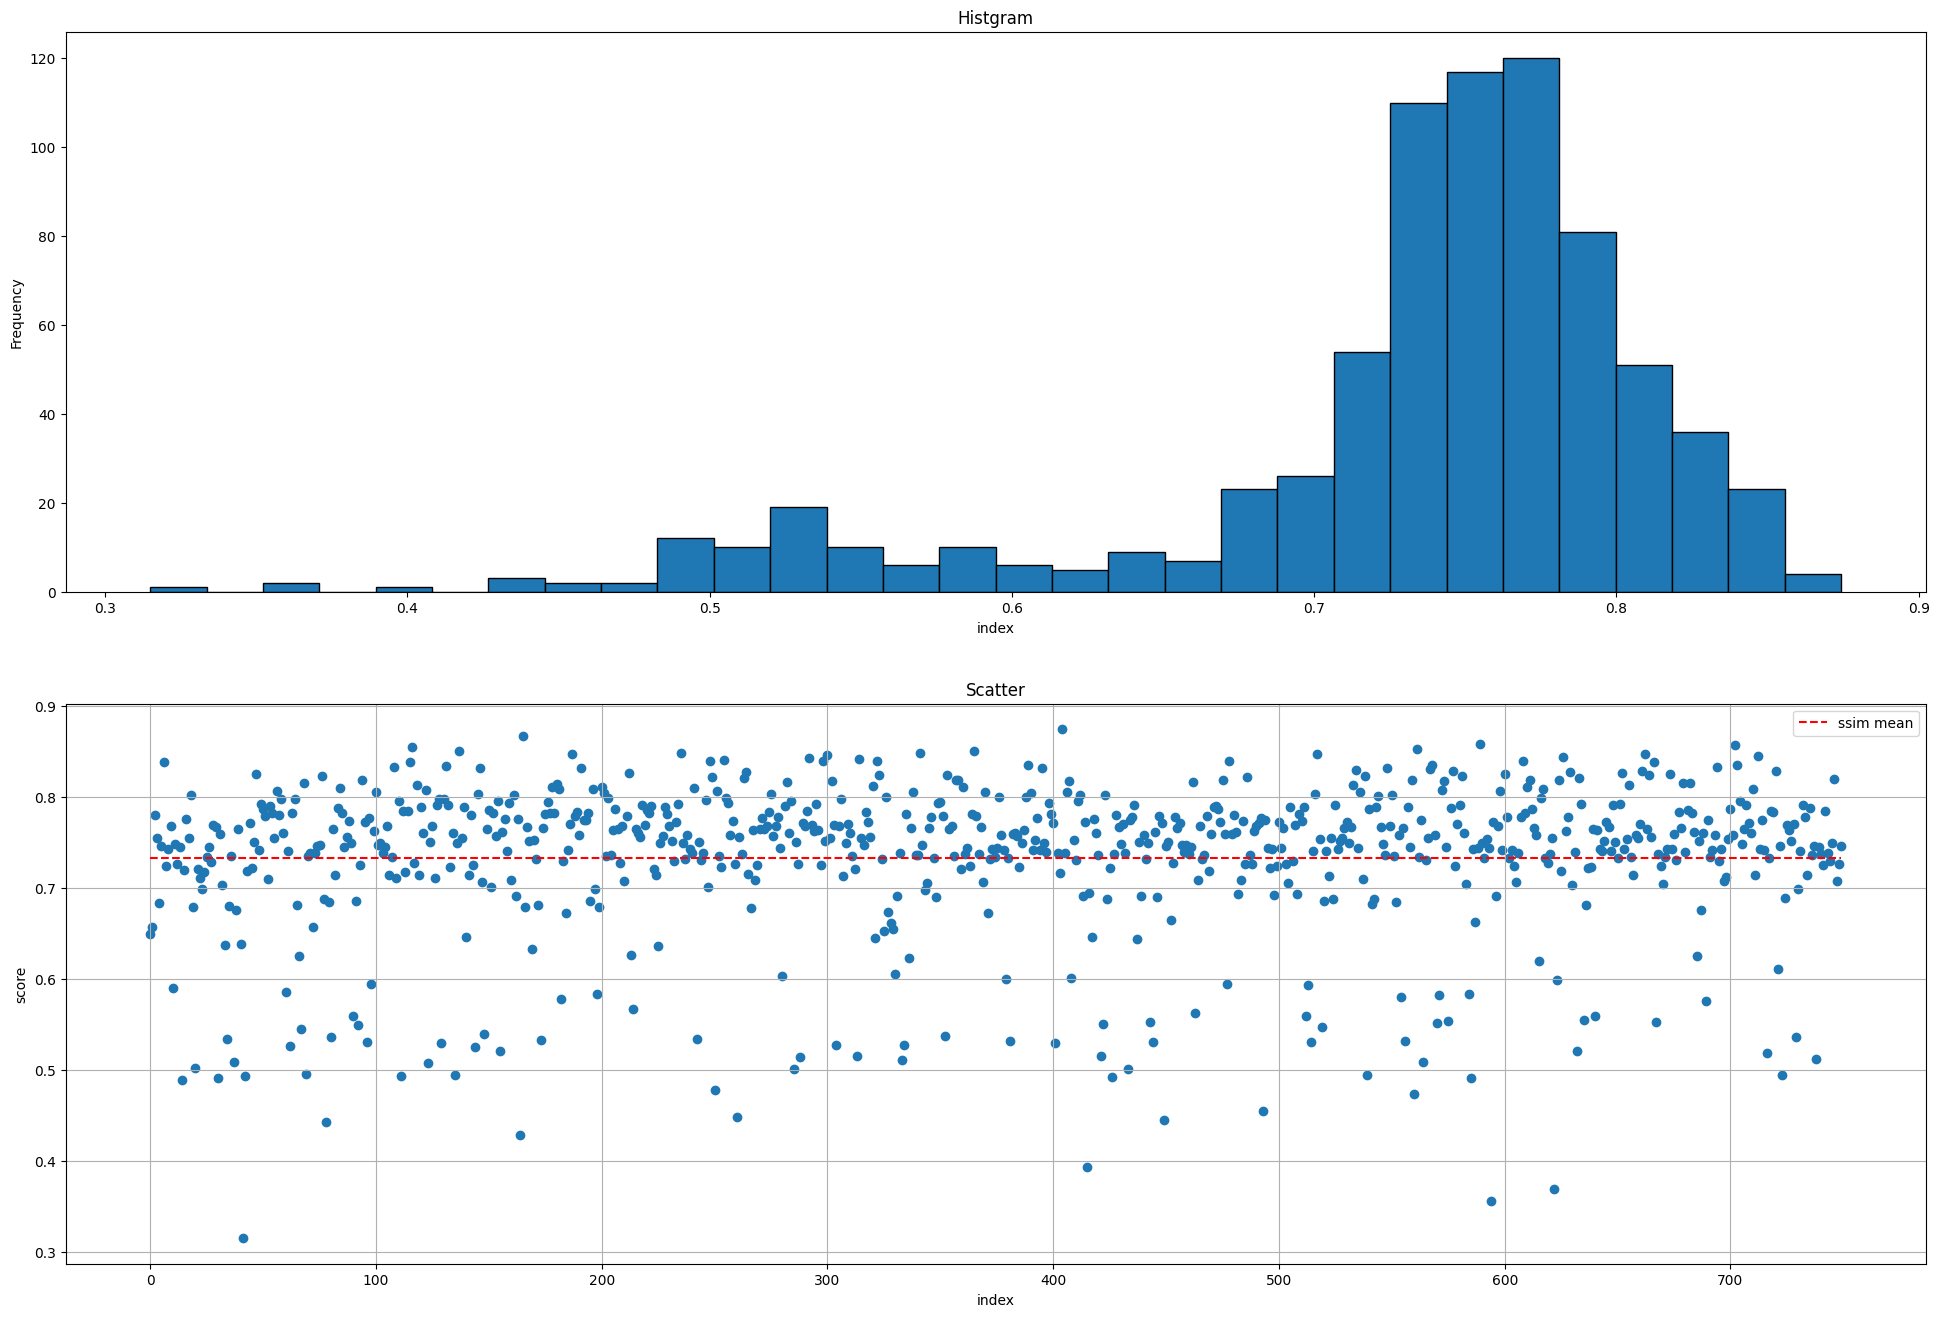

In [ ]:
print(f"SSIM scikit-image => 平均: {np.mean(SCORES, axis=0)} 最大: {np.max(SCORES, axis=0)} 最小: {np.min(SCORES, axis=0)}")

def visualize_scores(scores, metrics_name='ssim'):
    # 分布とヒストグラムの可視化
    x = range(len(scores))
    m = np.mean(scores)

    fig = plt.figure(figsize=(24, 16), facecolor='white')
    
    ax = fig.add_subplot(2, 1, 1)
    ax.hist(scores, bins=30, histtype='barstacked', ec='black')                        # ヒストグラムをプロット
    ax.set_title('Histgram')                     # 図のタイトル
    ax.set_xlabel('index') # x軸のラベル
    ax.set_ylabel('Frequency')                                # y軸のラベル
    
    ax = fig.add_subplot(2, 1, 2)
    ax.scatter(x=x, y=scores) # 散布図をプロット
    ax.plot([0, len(scores)-1],[m, m], "red", linestyle='dashed', label='ssim mean')
    ax.set_title('Scatter')             # 図のタイトル
    ax.set_xlabel('index') # x軸のラベル
    ax.set_ylabel('score')                # y軸のラベル
    ax.grid(True) # グリッド線を表示
    plt.legend()
    plt.savefig(f'{logging_dir}/histgram-scatter_{metrics_name}.png')
    plt.show();
    
visualize_scores(SCORES)

## Inference Submit

In [ ]:
cfg.DATA_ROOT

'../../data/'

In [ ]:
PATHS_LOW_TEST = sorted(glob(f'{cfg.DATA_ROOT}/test/test_*_low.tif'))
test_df = pd.DataFrame({'path_low': PATHS_LOW_TEST})
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   path_low  400 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


In [ ]:
test_ds = SolafuneSR2023Dataset(test_df, phase='test')
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

SAVE_DIR = f'{logging_dir}/submit/'
os.makedirs(SAVE_DIR, exist_ok=True)

FNAMES, PATHS, SCORES,  = [], [], []

for image, paths in tqdm(test_dl, leave=False):
    image = image.to(device)
    
    with torch.no_grad():
        logits = model(image)
        preds = torch.round(logits, decimals=0)
    
    preds = preds.cpu().numpy().transpose(0, 2, 3, 1).astype(np.uint8)
    
    # per batch
    for i in range(preds.shape[0]):
        pred_h = preds[i]
        path = paths[i]
        
        PATHS.append(path)
        SCORES.append(ssim_score)
        
        FNAME = os.path.basename(path).replace("_low.tif", "_answer.tif")
        FNAMES.append(FNAME)
        tifffile.imwrite(f'{SAVE_DIR}/{FNAME}', pred_h)

df_preds = pd.DataFrame()
df_preds['file_name'] = FNAMES
df_preds['path'] = PATHS

PATH_PRED = f'{logging_dir}/submit_fold{fold}.csv'
df_preds.to_csv(PATH_PRED, index=False)
print(F'>>> csv: {PATH_PRED}')

display(df_preds.head(8))

>>> csv: output/A6000_V1_IMG130_SwinIR_W7D6E60H6Unc_AdamW0.0011e-05_E100_fl-tr_B8/A6000_fold0/submit_fold0.csv


,file_name,path
0,test_0_answer.tif,../../data//test/test_0_low.tif
1,test_100_answer.tif,../../data//test/test_100_low.tif
2,test_101_answer.tif,../../data//test/test_101_low.tif
3,test_102_answer.tif,../../data//test/test_102_low.tif
4,test_103_answer.tif,../../data//test/test_103_low.tif
5,test_104_answer.tif,../../data//test/test_104_low.tif
6,test_105_answer.tif,../../data//test/test_105_low.tif
7,test_106_answer.tif,../../data//test/test_106_low.tif


## Submit

In [ ]:
PATH_ZIP = f'{logging_dir}/submit.zip'
PATH_SUBMITS = f'{SAVE_DIR}*.tif'
print(PATH_ZIP, PATH_SUBMITS)

output/A6000_V1_IMG130_SwinIR_W7D6E60H6Unc_AdamW0.0011e-05_E100_fl-tr_B8/A6000_fold0/submit.zip output/A6000_V1_IMG130_SwinIR_W7D6E60H6Unc_AdamW0.0011e-05_E100_fl-tr_B8/A6000_fold0/submit/*.tif


In [ ]:
!zip -j {PATH_ZIP} {PATH_SUBMITS}

  adding: test_0_answer.tif (deflated 24%)
  adding: test_100_answer.tif (deflated 25%)
  adding: test_101_answer.tif (deflated 32%)
  adding: test_102_answer.tif (deflated 28%)
  adding: test_103_answer.tif (deflated 38%)
  adding: test_104_answer.tif (deflated 39%)
  adding: test_105_answer.tif (deflated 33%)
  adding: test_106_answer.tif (deflated 46%)
  adding: test_107_answer.tif (deflated 45%)
  adding: test_108_answer.tif (deflated 37%)
  adding: test_109_answer.tif (deflated 37%)
  adding: test_10_answer.tif (deflated 23%)
  adding: test_110_answer.tif (deflated 29%)
  adding: test_111_answer.tif (deflated 38%)
  adding: test_112_answer.tif (deflated 23%)
  adding: test_113_answer.tif (deflated 36%)
  adding: test_114_answer.tif (deflated 34%)
  adding: test_115_answer.tif (deflated 31%)
  adding: test_116_answer.tif (deflated 30%)
  adding: test_117_answer.tif (deflated 41%)
  adding: test_118_answer.tif (deflated 34%)
  adding: test_119_answer.tif (deflated 31%)
  adding: tes